# Modélisation pour la variable *TotalGHGEmissions*

<a id="0"></a> <br>
# Table of Contents  

1. [Premières observations](#1)
    * [1.1 Chargement du jeu de données](#2)
    * [1.2 Préparation des données](#3)
2.[Cross validation des modèles sans optimisation](#4)
3.[Optimisation des modèles](#5)
4.[Comparaison des modèles](#6)
5.[Prédictions pour chaque modèle](#7)
6.[Sélection du modèle](#8)
7.[Impact de l'Energy Star Score](#9)
8.[Feature Importance](#10)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fc
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_log_error,confusion_matrix

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import time

In [237]:
# Paramètres d'affichage
#pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# <a id="1"></a> 1. Premières observations
## <a id="2"></a> 1.1 Chargement du jeu de données

In [2]:
data = pd.read_csv('/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 4/data_cleaned.csv')

In [3]:
data_original = data.copy()

In [4]:
data.head()

,OSEBuildingID,Neighborhood,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,...,TotalGHGEmissions,BuildingAge,ElectricityUse,SteamUse,NaturalGasUse,SteamUseMost,NaturalGasUseMost,ElectricityUseMost,ParkingRatioGFA,MoreThan1Building
0,1,DOWNTOWN,12,88434,Hotel,88434.0,None,0.0,None,0.0,...,249.98,89,True,True,True,False,False,True,0.000000,False
1,2,DOWNTOWN,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,...,295.86,20,True,False,True,False,True,False,0.145453,False
2,3,DOWNTOWN,41,956110,Hotel,756493.0,None,0.0,None,0.0,...,2089.28,47,True,True,True,False,False,True,0.205748,False
3,5,DOWNTOWN,10,61320,Hotel,61320.0,None,0.0,None,0.0,...,286.43,90,True,True,True,False,False,True,0.000000,False
4,8,DOWNTOWN,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,...,505.01,36,True,False,True,False,True,False,0.353115,False


In [5]:
data.shape

(1477, 22)

In [6]:
data.columns

Index(['OSEBuildingID', 'Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtype='object')

In [7]:
data.dtypes

OSEBuildingID                        int64
Neighborhood                        object
NumberofFloors                       int64
PropertyGFATotal                     int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEnergyUse(kBtu)                float64
TotalGHGEmissions                  float64
BuildingAge                          int64
ElectricityUse                        bool
SteamUse                              bool
NaturalGasUse                         bool
SteamUseMost                          bool
NaturalGasUseMost                     bool
ElectricityUseMost                    bool
ParkingRatioGFA                    float64
MoreThan1Building                     bool
dtype: object

In [8]:
data['TotalGHGEmissions'].describe()

count     1477.000000
mean       183.695518
std        740.491090
min         -0.800000
25%         20.080000
50%         49.250000
75%        142.390000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

## <a id="3"></a>  1.2 Préparation des données

Nous allons supprimer les valeurs de *TotalGHGEmissions* qui sont inférieures à 0, qui sont au nombre de 2.

In [9]:
data['TotalGHGEmissions'].loc[data['TotalGHGEmissions']<=0]

433     0.0
1425   -0.8
Name: TotalGHGEmissions, dtype: float64

In [10]:
idx = data['TotalGHGEmissions'].loc[data['TotalGHGEmissions']<=0].index

In [11]:
fc.drop_lignes(data,idx)

Suppression effectuée


In [12]:
X_ghg = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'],axis=1)
y_ghg = data.copy()['TotalGHGEmissions']

In [13]:
# 20% des données dans le jeu de test
X_train_ghg, X_test_ghg, y_train_ghg, y_test_ghg = train_test_split(X_ghg, y_ghg,test_size=0.2,random_state=0)

In [14]:
col_quanti = X_ghg.select_dtypes(['int32','float64']).columns

col_quali = X_ghg.select_dtypes(['category','object','bool']).columns

In [15]:
std_scale = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scale,col_quanti),
    ('quali',ohe,col_quali)
])

In [253]:
X_train_ghg.shape

(1180, 18)

In [254]:
X_test_ghg.shape

(295, 18)

In [255]:
y_train_ghg_log = np.log(y_train_ghg)

On peut observer la différence entre la distribution de la target *SiteEnergyUse(kBtu)* et sa distribution après sa transformation.

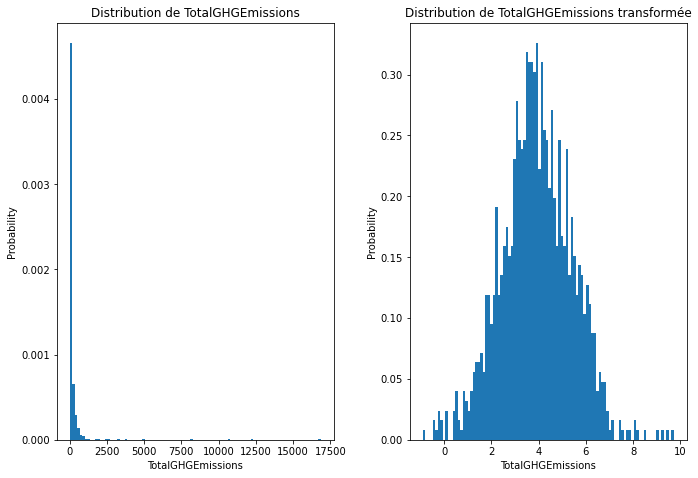

In [256]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,7))

ax0.hist(y_train_ghg, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("TotalGHGEmissions")
ax0.set_title("Distribution de TotalGHGEmissions")

ax1.hist(y_train_ghg_log, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("TotalGHGEmissions")
ax1.set_title("Distribution de TotalGHGEmissions transformée")

plt.tight_layout(pad=2)


# <a id="4"></a> 2. Cross validation des modèles sans optimisation 

In [259]:
resultats_cv_y_ghg = fc.cross_valid(X_train_ghg,y_train_ghg,preprocessor)

In [260]:
resultats_cv_y_ghg

,RMSE,R2,MAE,MedAE,FIT_TIME,SCORE_TIME
dum,6.087442e+02,-8.539437e-02,2.052717e+02,140.955136,0.019876,0.019357
lr,1.008567e+13,-8.221827e+21,1.573302e+12,92.555625,0.031501,0.009743
ridge,5.920284e+02,-1.109808e+00,2.073632e+02,90.754638,0.016072,0.008352
lasso,6.100569e+02,-1.919966e+00,1.867632e+02,72.390619,0.016232,0.008242
ElasticNet,5.915412e+02,-3.121091e-01,1.762048e+02,67.803199,0.016598,0.009005
RandomForest,4.212455e+02,-1.216255e+00,9.987566e+01,25.025780,0.806585,0.020757
KNR,5.376574e+02,1.701410e-01,1.261488e+02,27.051400,0.016067,0.022105
SVR,6.079667e+02,-2.696758e-02,1.455776e+02,26.750827,0.107711,0.052035
XGBR,3.554972e+02,-2.413674e+00,9.241721e+01,27.513646,0.436306,0.012672


In [261]:
resultats_cv_y_ghg_log = fc.cross_valid(X_train_ghg,y_train_ghg_log,preprocessor)

In [262]:
resultats_cv_y_ghg_log

,RMSE,R2,MAE,MedAE,FIT_TIME,SCORE_TIME
dum,1.491073e+00,-1.518917e-02,1.169503e+00,0.954433,0.019423,0.012079
lr,3.398999e+10,-1.342673e+21,5.184132e+09,0.634092,0.018480,0.007810
ridge,9.022880e-01,6.274067e-01,7.139222e-01,0.613338,0.012910,0.007394
lasso,1.491073e+00,-1.518917e-02,1.169503e+00,0.954433,0.012705,0.007624
ElasticNet,1.424688e+00,7.296317e-02,1.119958e+00,0.923315,0.013088,0.007850
RandomForest,7.932584e-01,7.114382e-01,6.007466e-01,0.459774,0.610457,0.018981
KNR,9.328690e-01,6.011874e-01,7.279353e-01,0.594728,0.016503,0.018248
SVR,8.033684e-01,7.043327e-01,6.169765e-01,0.516830,0.103894,0.047677
XGBR,7.675397e-01,7.299258e-01,5.910919e-01,0.469872,0.429936,0.012721


De manière générale, on observe une amélioration des performances des différents modèles lorsque la target a été transformée en log. Nous continuerons donc avec cette configuration.


# <a id="5"></a> 3. Optimisation des modèles 

In [16]:
def grid_search_cv(model,params):
    
    grid = Pipeline([('preprocessor', preprocessor),('grid_search', GridSearchCV(
        TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),
        param_grid=params,
        cv=5,
        scoring=('neg_root_mean_squared_error','r2','neg_mean_absolute_error','neg_median_absolute_error', 'neg_mean_squared_log_error'),
        return_train_score = True,
        refit='r2',
        n_jobs = -1
    ))])
    
    return grid

In [265]:
params_dum = {'regressor__strategy': ['mean', 'median']}
model_dum_ghg = grid_search_cv(DummyRegressor(),params_dum)
model_dum_ghg.fit(X_train_ghg,y_train_ghg)
model_dum_ghg_resultats = fc.metrics(model_dum_ghg)

Meilleurs paramètres {'regressor__strategy': 'mean'}
Meilleur score RMSLE : -2.020925672999176
Meilleur score RMSE : -614.9163995889709
Meilleur score R2 : -0.07475391783075938
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__strategy,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
0,0.008064,0.004922,0.003299,0.000301,mean,{'regressor__strategy': 'mean'},-304.120333,-1522.853775,-354.907421,-732.268217,-160.432253,-614.9164,491.706504,1,-866.778899,-441.872772,-862.604574,-800.279373,-876.048232,-769.51677,165.994663,-0.071711,-0.031298,-0.144451,-0.023843,-0.102467,-0.074754,0.044979,1,-0.025624,-0.046041,-0.023118,-0.026688,-0.027101,-0.029714,0.00828,-110.52986,-292.714658,-148.621928,-140.300189,-85.207379,-155.474803,72.207434,1,-166.555318,-120.9426,-156.974256,-159.100936,-172.989713,-155.312565,18.095792,-40.2,-37.062811,-38.125,-41.427207,-39.843075,-39.331619,1.549876,2,-39.055936,-38.532811,-36.772657,-38.592207,-40.49,-38.688722,1.190326,-1.91472,-2.220945,-2.092214,-2.036571,-1.840178,-2.020926,0.133629,1,-2.032875,-1.959529,-1.997889,-2.002625,-2.05146,-2.008876,0.031573


In [266]:
params_lr =  {"regressor__fit_intercept": [True, False],
             "regressor__positive": [True, False]
             }

model_lr_ghg = grid_search_cv(LinearRegression(),params_lr)
model_lr_ghg.fit(X_train_ghg,y_train_ghg)
model_lr_ghg_resultats = fc.metrics(model_lr_ghg)

Meilleurs paramètres {'regressor__fit_intercept': False, 'regressor__positive': True}
Meilleur score RMSLE : -0.833474311507184
Meilleur score RMSE : -3844.0645107358127
Meilleur score R2 : -27.125725848122926
Résultats des meilleurs paramètres :



One or more of the test scores are non-finite: [-4454.86198584            nan -3844.06451074            nan]
One or more of the test scores are non-finite: [-36.15448758          nan -27.12572585          nan]
One or more of the test scores are non-finite: [-408.59022842           nan -354.15342567           nan]
One or more of the test scores are non-finite: [-24.47238759          nan -23.46200276          nan]
One or more of the test scores are non-finite: [-1.30851333         nan -0.83347431         nan]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,param_regressor__positive,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
2,0.050138,0.005551,0.003031,0.000705,False,True,"{'regressor__fit_intercept': False, 'regressor...",-944.288274,-13877.898681,-1910.1436,-2317.914107,-170.077891,-3844.064511,5072.551492,1,-3989.000576,-2406.370461,-4519.883921,-3483.220549,-3661.118143,-3611.91873,698.415627,-9.332275,-84.647559,-32.151186,-9.258589,-0.239019,-27.125726,30.635773,1,-20.721987,-30.022658,-27.090331,-18.449893,-16.938442,-22.644662,5.060682,-135.95129,-1058.337103,-234.100883,-267.68469,-74.693161,-354.153426,358.740663,1,-262.501637,-172.472387,-290.316277,-210.147577,-255.757428,-238.239061,41.765989,-20.421426,-25.619121,-26.538137,-24.489493,-20.241838,-23.462003,2.637653,1,-19.732915,-19.177716,-16.889679,-17.537447,-20.547893,-18.77713,1.364469,-0.747482,-0.797582,-0.884672,-0.860839,-0.876796,-0.833474,0.052782,1,-0.565709,-0.537643,-0.549392,-0.543962,-0.54168,-0.547677,0.009783


In [267]:
params_ridge =  {'regressor__alpha': np.arange(0, 2000, 100)}
model_ridge_ghg = grid_search_cv(Ridge(),params_ridge)
model_ridge_ghg.fit(X_train_ghg,y_train_ghg)
model_ridge_ghg_resultats = fc.metrics(model_ridge_ghg)

Meilleurs paramètres {'regressor__alpha': 1000}
Meilleur score RMSLE : -0.8555041795921629
Meilleur score RMSE : -461.4753142094793
Meilleur score R2 : 0.13175520402201019
Résultats des meilleurs paramètres :



One or more of the test scores are non-finite: [           nan -1131.61019521  -698.07967136  -527.33630168
  -471.09314593  -461.47531421  -468.01574347  -479.66826309
  -492.40171586  -504.65178049  -515.8306315   -525.7745399
  -534.50798013  -542.13373104  -548.78017987  -554.57652761
  -559.64195329  -564.08172693  -567.98667495  -571.43415318]
One or more of the test scores are non-finite: [        nan -5.27957362 -2.1655603  -0.93763445 -0.37847638 -0.10840059
  0.02517105  0.09045168  0.12020742  0.1310509   0.1317552   0.12709429
  0.11971993  0.11112208  0.10213898  0.09323664  0.0846657   0.07655144
  0.06894623  0.06186045]
One or more of the test scores are non-finite: [          nan -179.99626233 -145.15608823 -132.4888357  -125.90882997
 -127.66811525 -129.37585614 -130.86972094 -132.16224315 -133.36602586
 -134.55748116 -135.66795376 -136.68875773 -137.56793672 -138.3336451
 -139.00653513 -139.60177392 -140.2023555  -140.74384444 -141.2302085 ]
One or more of the test s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
10,0.008098,0.00221,0.00354,0.000702,1000,{'regressor__alpha': 1000},-304.801498,-1168.846029,-322.333074,-634.725308,-148.447248,-515.830632,362.632101,7,-652.760372,-391.599524,-682.727356,-571.37026,-659.925194,-591.676541,106.885473,-0.076517,0.39245,0.05599,0.230755,0.056099,0.131755,0.162852,1,0.418327,0.178442,0.35909,0.476652,0.417164,0.369935,0.102711,-101.96971,-245.74802,-127.716738,-125.537226,-71.815713,-134.557481,59.143874,8,-139.683319,-105.721035,-135.220768,-132.693136,-146.643043,-131.99226,13.963449,-24.854574,-25.10882,-25.38679,-27.536003,-25.56436,-25.69011,0.954061,10,-25.481578,-24.925877,-24.168422,-25.486524,-26.657836,-25.344047,0.815134,-1.234806,-1.317898,-1.274576,-1.239038,-1.190385,-1.251341,0.042685,10,-1.233871,-1.221402,-1.229534,-1.239249,-1.241146,-1.23304,0.007109


In [268]:
params_lasso =  {'regressor__alpha': np.arange(0.0, 1.0, 0.001)}

model_lasso_ghg = grid_search_cv(Lasso(),params_lasso)
model_lasso_ghg.fit(X_train_ghg,y_train_ghg)
model_lasso_ghg_resultats = fc.metrics(model_lasso_ghg)

Meilleurs paramètres {'regressor__alpha': 0.395}
Meilleur score RMSLE : -0.7147829776224174
Meilleur score RMSE : -590.113251269898
Meilleur score R2 : 0.015180897405754346
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
395,0.006318,0.000253,0.003583,0.000336,0.395,{'regressor__alpha': 0.395},-295.666693,-1483.793734,-342.482016,-691.070577,-149.275714,-592.457747,479.830687,73,-822.745474,-422.93579,-818.606212,-773.709399,-830.375303,-733.674435,156.626574,-0.012958,0.020928,-0.065719,0.08812,0.045534,0.015181,0.052175,1,0.075935,0.041697,0.078591,0.040354,0.077203,0.062756,0.017768,-104.94695,-283.788815,-139.391359,-130.526611,-77.784553,-147.287658,71.553151,21,-155.808421,-112.973766,-147.550588,-150.162573,-162.371083,-145.773286,17.17221,-34.706825,-33.326279,-33.414872,-36.457251,-32.168633,-34.014772,1.461969,396,-34.142955,-34.130044,-32.138313,-34.291766,-35.649893,-34.070594,1.121212,-1.607226,-1.786941,-1.730814,-1.644424,-1.576944,-1.66927,0.078263,396,-1.649407,-1.666872,-1.619432,-1.676675,-1.654374,-1.653352,0.019462


In [269]:
params_elastic =  {'regressor__alpha': np.arange(0.0, 1.1, 0.001),
                   'regressor__l1_ratio': np.arange(0.0, 1.1, 0.1)
                  }

model_elastic_ghg = grid_search_cv(ElasticNet(),params_elastic)
model_elastic_ghg.fit(X_train_ghg,y_train_ghg)
model_elastic_ghg_resultats = fc.metrics(model_elastic_ghg)

Meilleurs paramètres {'regressor__alpha': 1.014, 'regressor__l1_ratio': 0.0}
Meilleur score RMSLE : -0.7147829776224174
Meilleur score RMSE : -461.41763260419145
Meilleur score R2 : 0.13232515158210387
Résultats des meilleurs paramètres :



Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.692e+02, tolerance: 2.611e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
11154,0.259679,0.01994,0.004751,0.001323,1.014,0.0,"{'regressor__alpha': 1.014, 'regressor__l1_rat...",-308.358647,-1146.902383,-321.610399,-629.834941,-149.271488,-511.195572,353.913223,677,-642.516967,-389.519458,-673.53647,-559.861515,-650.273983,-583.141678,104.148855,-0.101791,0.415048,0.060218,0.242563,0.045588,0.132325,0.178671,1,0.436439,0.187146,0.37623,0.497523,0.434087,0.386285,0.106707,-102.446655,-243.355186,-127.340934,-125.29723,-71.689687,-134.025938,58.235425,714,-138.847379,-105.582178,-134.629381,-131.885284,-145.978011,-131.384447,13.749218,-24.488883,-24.933148,-24.840016,-27.237697,-25.446589,-25.389267,0.973693,3317,-25.266111,-24.752837,-23.979694,-25.534399,-26.401833,-25.186974,0.806083,-1.223882,-1.305367,-1.263091,-1.227191,-1.179745,-1.239855,0.042096,3677,-1.222356,-1.209672,-1.217602,-1.227701,-1.229538,-1.221374,0.007195


In [270]:
params_knr =  {"regressor__n_neighbors": list(range(2, 21)), 
               "regressor__weights": ['uniform', 'distance'], 
               "regressor__leaf_size": list(range(0, 35)),
               "regressor__p": [1,2]
              }

model_knr_ghg = grid_search_cv(KNeighborsRegressor(),params_knr)
model_knr_ghg.fit(X_train_ghg,y_train_ghg)
model_knr_ghg_resultats = fc.metrics(model_knr_ghg)

Meilleurs paramètres {'regressor__leaf_size': 0, 'regressor__n_neighbors': 2, 'regressor__p': 1, 'regressor__weights': 'distance'}
Meilleur score RMSLE : -0.7725467258128161
Meilleur score RMSE : -422.68856283993085
Meilleur score R2 : 0.4483716495922597
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__leaf_size,param_regressor__n_neighbors,param_regressor__p,param_regressor__weights,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
1,0.003551,0.000434,0.058728,0.002533,0,2,1,distance,"{'regressor__leaf_size': 0, 'regressor__n_neig...",-230.685898,-1215.190859,-271.858319,-270.283156,-125.424581,-422.688563,399.816948,1,-2.576552e-13,-1.406312e-13,-2.560458e-13,-2.285616e-13,-2.593529e-13,-2.284494e-13,4.534672e-14,0.383364,0.343316,0.32849,0.860514,0.326174,0.448372,0.207088,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-88.950894,-201.367474,-113.738344,-82.877477,-64.018472,-110.190532,48.280029,1,-4.551068e-14,-3.110412e-14,-4.282685e-14,-4.143155e-14,-4.669335e-14,-4.151331e-14,5.529828e-15,-22.110236,-25.738577,-29.544413,-28.295855,-22.913434,-25.720503,2.904091,2626,-3.552714e-15,-3.552714e-15,-3.552714e-15,-3.552714e-15,-7.105427e-15,-4.263256e-15,1.421085e-15,-0.928323,-0.875114,-0.994141,-0.752968,-0.910162,-0.892142,0.07962,2486,-1.186634e-31,-1.096801e-31,-1.089489e-31,-1.145373e-31,-1.149552e-31,-1.133570e-31,3.607118e-33


In [271]:
params_svr =  {'regressor__kernel': ['linear','poly', 'rbf', 'sigmoid'],
               'regressor__degree': [1,2,3,5],
               'regressor__gamma' : [1e-8, 1e-5, 1e-3, 1e-2, 1e-1],
               'regressor__C': [0.01, 0.1, 1, 10],
               'regressor__epsilon' : [0.001, 0.01, 0.1, 0.5, 1]
                  }

model_svr_ghg = grid_search_cv(SVR(),params_svr)
model_svr_ghg.fit(X_train_ghg,y_train_ghg)
model_svr_ghg_resultats = fc.metrics(model_svr_ghg)

One or more of the test scores are non-finite: [-2.09390601e+03 -6.15372689e+02 -6.15372381e+02 ... -9.87851288e+07
 -5.20720829e+02 -1.46885075e+46]
invalid value encountered in subtract
One or more of the test scores are non-finite: [-1.54171145e+01 -7.81260938e-02 -7.81239219e-02 ... -2.15628403e+10
  3.61315463e-01 -1.98316892e+87]
One or more of the test scores are non-finite: [-2.77058510e+02 -1.55499098e+02 -1.55499126e+02 ... -6.43110617e+06
 -1.14623118e+02 -9.56170446e+44]
overflow encountered in square
One or more of the test scores are non-finite: [ -22.26135413  -37.7879098   -37.78906338 ...  -21.99273848  -21.24229137
 -597.36743505]
One or more of the test scores are non-finite: [  -0.88896121   -2.02212527   -2.02212549 ...   -1.09441693   -0.60057348
 -476.66738524]


Meilleurs paramètres {'regressor__C': 10, 'regressor__degree': 1, 'regressor__epsilon': 0.1, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}
Meilleur score RMSLE : -0.5248285693124305
Meilleur score RMSE : -429.9679168950467
Meilleur score R2 : 0.51680296851773
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__C,param_regressor__degree,param_regressor__epsilon,param_regressor__gamma,param_regressor__kernel,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
1254,0.158985,0.004734,0.078366,0.00586,10,1,0.1,0.01,rbf,"{'regressor__C': 10, 'regressor__degree': 1, '...",-194.621071,-1224.262821,-221.642624,-394.209721,-115.103348,-429.967917,407.458048,1,-206.299487,-236.877614,-168.365782,-155.608777,-207.172849,-194.864902,29.293515,0.561099,0.333474,0.553652,0.703279,0.43251,0.516803,0.125545,1,0.941901,0.699391,0.961023,0.961183,0.942559,0.901211,0.101263,-67.328412,-192.212122,-92.948732,-90.629363,-53.245456,-99.272817,48.767573,1,-63.619103,-59.545499,-56.424222,-57.822725,-65.554895,-60.593289,3.462025,-17.064259,-21.765736,-23.385503,-23.774961,-17.55126,-20.708344,2.861326,7,-16.34114,-16.357955,-14.947887,-16.141985,-16.448805,-16.047554,0.558879,-0.428677,-0.698422,-0.566605,-0.566797,-0.574832,-0.567067,0.085401,21,-0.450866,-0.411749,-0.425305,-0.420379,-0.415363,-0.424732,0.013846


In [272]:
model_svr_ghg.score(X_train_ghg,y_train_ghg)

0.9382566144535222

In [273]:
params_rf =  {'regressor__n_estimators' : [100, 200, 500, 800, 1000, 2000],
              'regressor__max_depth': [1, 2, 3, 4, 5, None],
                  }

model_rf_ghg = grid_search_cv(RandomForestRegressor(),params_rf)
model_rf_ghg.fit(X_train_ghg,y_train_ghg)
model_rf_ghg_resultats = fc.metrics(model_rf_ghg)

Meilleurs paramètres {'regressor__max_depth': None, 'regressor__n_estimators': 800}
Meilleur score RMSLE : -0.5573766507372213
Meilleur score RMSE : -452.5489534574226
Meilleur score R2 : 0.5095334858709062
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
33,8.888264,0.134684,0.14732,0.007822,None,800,"{'regressor__max_depth': None, 'regressor__n_e...",-178.592757,-1231.377188,-220.392112,-536.952523,-98.622889,-453.187494,416.631203,3,-436.704759,-223.795868,-408.873537,-409.776812,-407.8577,-377.401735,77.560037,0.630415,0.325705,0.558674,0.449491,0.583382,0.509533,0.109434,1,0.739656,0.731677,0.770131,0.730816,0.777375,0.749931,0.019826,-63.391346,-205.338685,-92.968331,-92.255613,-48.353781,-100.461551,55.15817,2,-55.897855,-37.445051,-48.967403,-50.719592,-53.766671,-49.359315,6.420762,-17.509015,-22.735772,-25.579883,-18.463604,-16.571989,-20.172052,3.428945,4,-7.14668,-6.942695,-6.518653,-6.808712,-7.370064,-6.957361,0.290152,-0.403819,-0.712054,-0.592109,-0.561067,-0.532872,-0.560384,0.099278,3,-0.084372,-0.070752,-0.073104,-0.074253,-0.075752,-0.075647,0.004658


In [274]:
model_rf_ghg.score(X_train_ghg,y_train_ghg)

0.7785597084312199

In [275]:
params_xgb = {'regressor__gamma': [0,0.001,0.01,0.1,0.5,1],
              'regressor__learning_rate' : [0.01, 0.1, 0.2, 0.3, 0.5],
              'regressor__max_depth': [2,4,6,7],
              'regressor__n_estimators': [50,100, 200, 300, 400],
             }


model_xgb_ghg = grid_search_cv(XGBRegressor(),params_xgb)
model_xgb_ghg.fit(X_train_ghg,y_train_ghg)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('quanti', StandardScaler(),
                                                  Index(['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ParkingRatioGFA'],
      dtype='object')),
                                                 ('quali',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['Neighborhood', 'LargestPropertyUseType',
       'SecondLarges...
                              param_grid={'regressor__gamma': [0, 0.001, 0.01,
                                                               0.1, 0.5, 1],
                                          'regressor__learning_rate': [0.01,
                                                                       0.1, 0.2,
                                                                       0.3,
                                                                       0.5],
                                          'regressor__max_depth': [2, 4, 6, 7],
                                          'regressor__n_estimators': [50, 100,
                                                                      200, 300,
                                                                      400]},
                              refit='r2', return_train_score=True,
                              scoring=('neg_root_mean_squared_error', 'r2',
                                       'neg_mean_absolute_error',
                                       'neg_median_absolute_error',
                                       'neg_mean_squared_log_error')))])

In [276]:
model_xgb_ghg_resultats = fc.metrics(model_xgb_ghg)

Meilleurs paramètres {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 300}
Meilleur score RMSLE : -0.4764790734228752
Meilleur score RMSE : -338.73401496209556
Meilleur score R2 : 0.6687246473455868
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
28,3.506589,0.044658,0.007908,0.000172,0,0.1,4,300,"{'regressor__gamma': 0, 'regressor__learning_r...",-140.646435,-1089.378453,-165.445837,-340.142309,-100.171453,-367.156897,370.299698,26,-111.615468,-87.569189,-140.758667,-186.567111,-112.141859,-127.730459,33.903129,0.770784,0.472254,0.751298,0.779091,0.570196,0.668725,0.124679,1,0.982993,0.958918,0.972757,0.944201,0.98317,0.968408,0.015004,-53.266791,-151.553261,-80.555536,-80.422512,-47.817962,-82.723212,36.969244,5,-40.113252,-33.923684,-36.919803,-43.34526,-39.805431,-38.821486,3.184531,-18.568004,-21.15913,-20.914079,-20.44063,-17.561114,-19.728592,1.414478,138,-11.914595,-11.405196,-11.036598,-11.60413,-11.861676,-11.564439,0.321406,-0.343077,-0.581634,-0.485641,-0.509214,-0.503373,-0.484588,0.077979,24,-0.199259,-0.17092,-0.170524,-0.178495,-0.18568,-0.180975,0.010704


In [277]:
model_xgb_ghg.score(X_train_ghg,y_train_ghg)

0.9730998439270655

# <a id="6"></a> 4. Comparaison des modèles 

Nous allons désormais comparer les résultats des différents modèles afin de sélectionner le plus pertinent pour notre étude. 

In [279]:
metrics = ['mean_test_neg_mean_squared_log_error','mean_test_r2','mean_test_neg_root_mean_squared_error',
           'mean_test_neg_mean_absolute_error','mean_test_neg_median_absolute_error','params','mean_fit_time',
          'mean_score_time']


compare_metrics_ghg = pd.concat([model_dum_ghg_resultats.loc[model_dum_ghg_resultats['params']==model_dum_ghg['grid_search'].best_params_][metrics],
                             model_lr_ghg_resultats.loc[model_lr_ghg_resultats['params']==model_lr_ghg['grid_search'].best_params_][metrics],
                             model_ridge_ghg_resultats.loc[model_ridge_ghg_resultats['params']==model_ridge_ghg['grid_search'].best_params_][metrics],
                             model_lasso_ghg_resultats.loc[model_lasso_ghg_resultats['params']==model_lasso_ghg['grid_search'].best_params_][metrics],
                             model_elastic_ghg_resultats.loc[model_elastic_ghg_resultats['params']==model_elastic_ghg['grid_search'].best_params_][metrics],
                             model_knr_ghg_resultats.loc[model_knr_ghg_resultats['params']==model_knr_ghg['grid_search'].best_params_][metrics],
                             model_svr_ghg_resultats.loc[model_svr_ghg_resultats['params']==model_svr_ghg['grid_search'].best_params_][metrics],
                             model_rf_ghg_resultats.loc[model_rf_ghg_resultats['params']==model_rf_ghg['grid_search'].best_params_][metrics],
                             model_xgb_ghg_resultats.loc[model_xgb_ghg_resultats['params']==model_xgb_ghg['grid_search'].best_params_][metrics]
                            ])

compare_metrics_ghg.reset_index(drop=True,inplace=True)
compare_metrics_ghg = compare_metrics_ghg.rename(index = {0:'dum',1:'lr',2:'ridge',3:'lasso',4:'ElasticNet',5:'KNR', 
                                6:'SVR',7:'RandomForest',8:'XGBR'})

In [280]:
compare_metrics_ghg

,mean_test_neg_mean_squared_log_error,mean_test_r2,mean_test_neg_root_mean_squared_error,mean_test_neg_mean_absolute_error,mean_test_neg_median_absolute_error,params,mean_fit_time,mean_score_time
dum,-2.020926,-0.074754,-614.916400,-155.474803,-39.331619,{'regressor__strategy': 'mean'},0.008064,0.003299
lr,-0.833474,-27.125726,-3844.064511,-354.153426,-23.462003,"{'regressor__fit_intercept': False, 'regressor...",0.050138,0.003031
ridge,-1.251341,0.131755,-515.830632,-134.557481,-25.690110,{'regressor__alpha': 1000},0.008098,0.003540
lasso,-1.669270,0.015181,-592.457747,-147.287658,-34.014772,{'regressor__alpha': 0.395},0.006318,0.003583
ElasticNet,-1.239855,0.132325,-511.195572,-134.025938,-25.389267,"{'regressor__alpha': 1.014, 'regressor__l1_rat...",0.259679,0.004751
KNR,-0.892142,0.448372,-422.688563,-110.190532,-25.720503,"{'regressor__leaf_size': 0, 'regressor__n_neig...",0.003551,0.058728
SVR,-0.567067,0.516803,-429.967917,-99.272817,-20.708344,"{'regressor__C': 10, 'regressor__degree': 1, '...",0.158985,0.078366
RandomForest,-0.560384,0.509533,-453.187494,-100.461551,-20.172052,"{'regressor__max_depth': None, 'regressor__n_e...",8.888264,0.147320
XGBR,-0.484588,0.668725,-367.156897,-82.723212,-19.728592,"{'regressor__gamma': 0, 'regressor__learning_r...",3.506589,0.007908


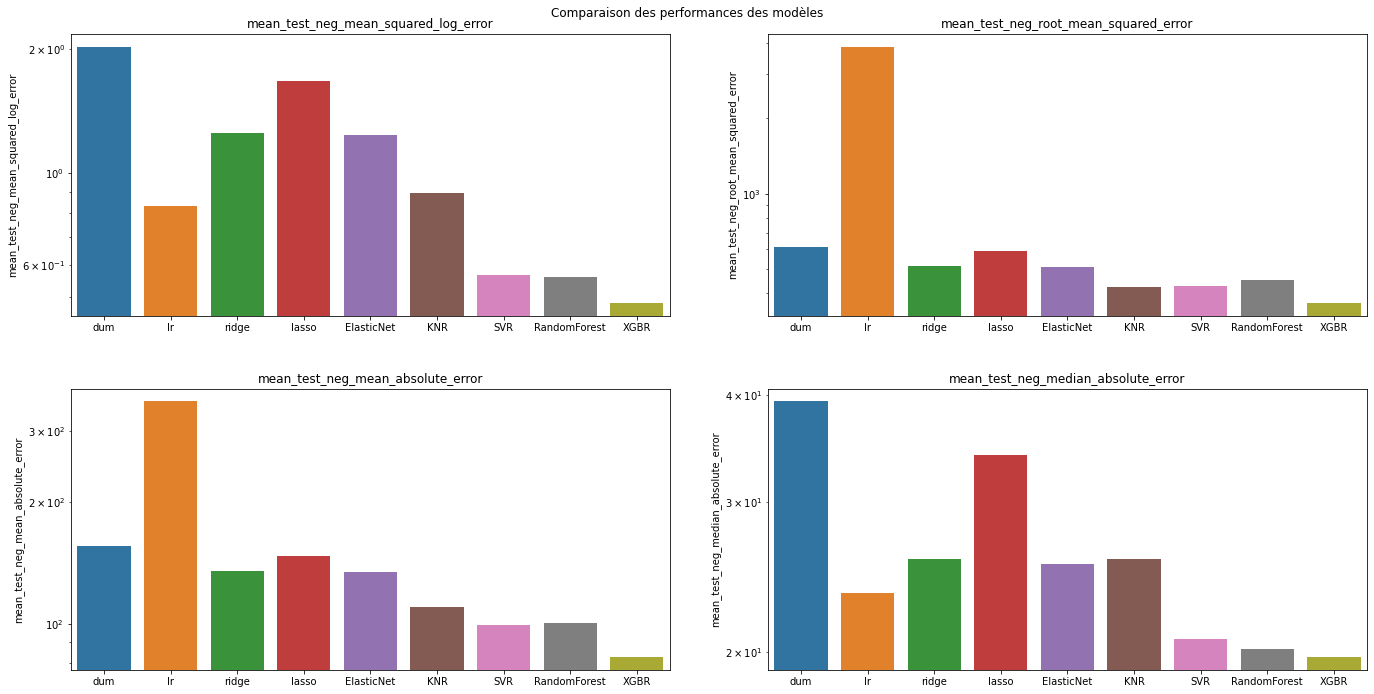

In [282]:
fc.bar_plot_compare(compare_metrics_ghg, compare_metrics_ghg.columns.drop(['params','mean_test_r2','mean_fit_time','mean_score_time']),True)

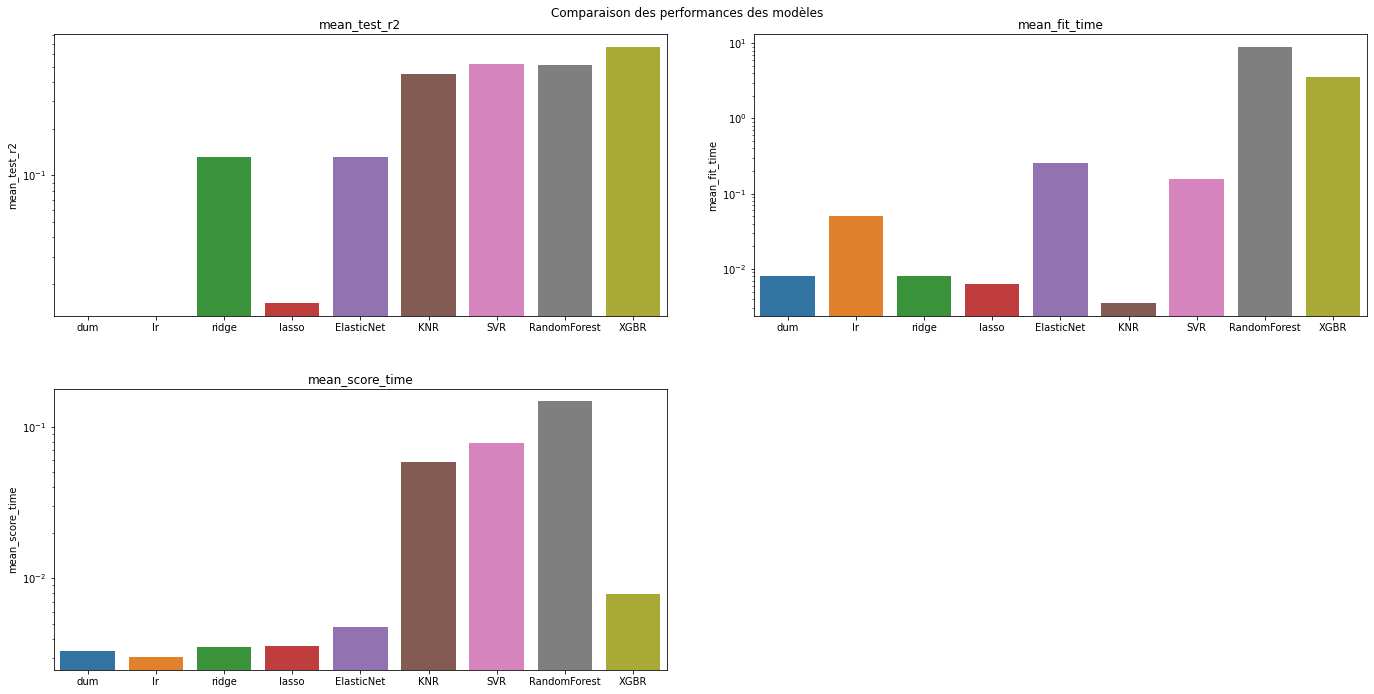

In [283]:
fc.bar_plot_compare(compare_metrics_ghg,['mean_test_r2','mean_fit_time','mean_score_time'],False)

# <a id="7"></a> 5. Prédictions pour chaque modèle

In [286]:
start_time = time.time()
y_pred_dum_ghg = model_dum_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.0093 s.


In [287]:
res_test_dum_ghg = fc.metrics_pred(y_test_ghg, y_pred_dum_ghg)
res_test_dum_ghg

,RMSLE,R2
0,2.313302,-0.080792


In [288]:
start_time = time.time()
y_pred_lr_ghg = model_lr_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.019 s.


In [289]:
res_test_lr_ghg = fc.metrics_pred(y_test_ghg, y_pred_lr_ghg)
res_test_lr_ghg

,RMSLE,R2
0,0.894189,-6.046447


In [290]:
start_time = time.time()
y_pred_ridge_ghg = model_ridge_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.016 s.


In [291]:
res_test_ridge_ghg = fc.metrics_pred(y_test_ghg, y_pred_ridge_ghg)
res_test_ridge_ghg

,RMSLE,R2
0,1.38399,0.051761


In [292]:
start_time = time.time()
y_pred_lasso_ghg = model_lasso_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.012 s.


In [293]:
res_test_lasso_ghg = fc.metrics_pred(y_test_ghg, y_pred_lasso_ghg)
res_test_lasso_ghg

,RMSLE,R2
0,1.833105,0.072206


In [294]:
start_time = time.time()
y_pred_elastic_ghg = model_elastic_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.017 s.


In [295]:
res_test_elastic_ghg = fc.metrics_pred(y_test_ghg, y_pred_elastic_ghg)
res_test_elastic_ghg

,RMSLE,R2
0,1.437801,0.061929


In [296]:
start_time = time.time()
y_pred_knr_ghg = model_knr_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.074 s.


In [297]:
res_test_knr_ghg = fc.metrics_pred(y_test_ghg, y_pred_knr_ghg)
res_test_knr_ghg

,RMSLE,R2
0,1.020747,0.23541


In [298]:
start_time = time.time()
y_pred_svr_ghg = model_svr_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.11 s.


In [299]:
res_test_svr_ghg = fc.metrics_pred(y_test_ghg, y_pred_svr_ghg)
res_test_svr_ghg

,RMSLE,R2
0,0.491438,0.611735


In [300]:
start_time = time.time()
y_pred_rf_ghg = model_rf_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.15 s.


In [301]:
res_test_rf_ghg = fc.metrics_pred(y_test_ghg, y_pred_rf_ghg)
res_test_rf_ghg

,RMSLE,R2
0,0.50291,0.51571


In [302]:
start_time = time.time()
y_pred_xgb_ghg = model_xgb_ghg.predict(X_test_ghg)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.015 s.


In [303]:
res_test_xgb_ghg = fc.metrics_pred(y_test_ghg, y_pred_xgb_ghg)
res_test_xgb_ghg

,RMSLE,R2
0,0.457038,0.644576


# <a id="8"></a> 6. Sélection du modèle

On choisit donc XGB Regressor qui offre un test score supérieur aux autres modèles ainsi que de meilleures performances en globalité. 

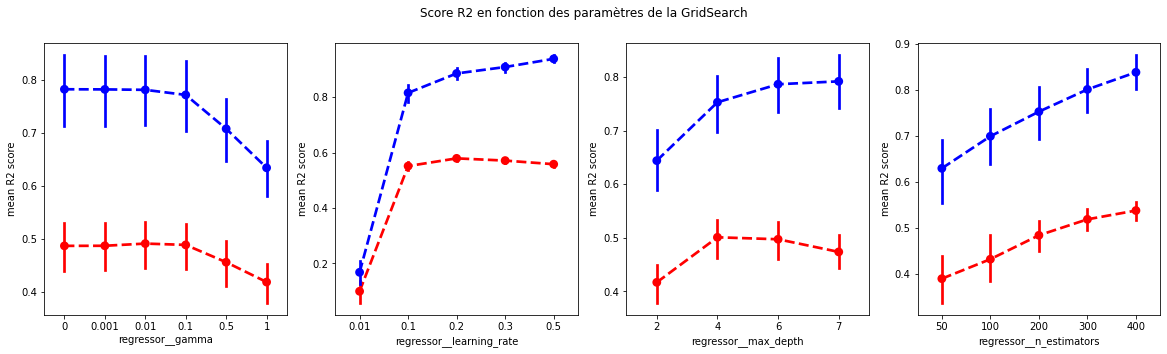

In [388]:
result = pd.DataFrame(model_xgb_ghg['grid_search'].cv_results_)

params_names = list(model_xgb_ghg['grid_search'].best_params_.keys())

fig, ax = plt.subplots(1,len(params_names),figsize=(20,5))

for i, param in enumerate(params_names) :
    sns.pointplot(x='param_' +param, y='mean_test_r2', data=result, 
                  #errorbar=result['std_test_r2'], 
                  linestyles = '--', markers = 'o', color = 'red', label= 'test', ax=ax[i])

    sns.pointplot(x='param_' +param, y='mean_train_r2', data=result, 
                  #errorbar=result['std_train_r2'], 
                  linestyles = '--', markers = 'o', color = 'blue', label= 'train', ax=ax[i])
    ax[i].set_xlabel(param)
    ax[i].set_ylabel('mean R2 score')

fig.suptitle('Score R2 en fonction des paramètres de la GridSearch')

plt.show()



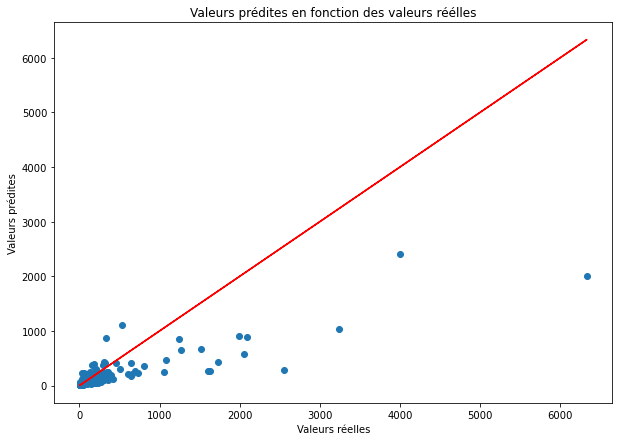

In [306]:
fc.plot_predict(y_test_ghg, y_pred_xgb_ghg)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


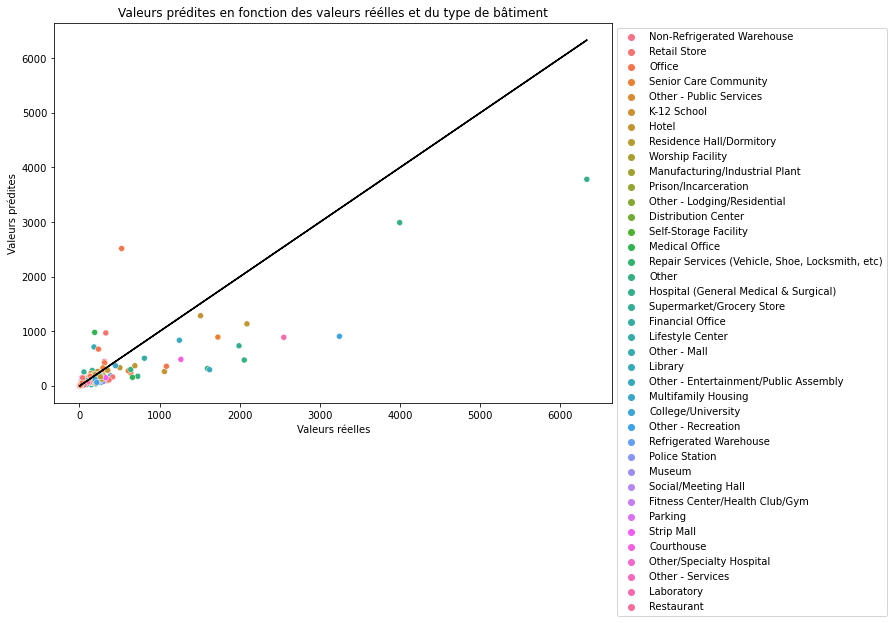

In [393]:
fc.plot_pred_class(y_test_ghg, y_pred_xgb_ghg,'LargestPropertyUseType')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


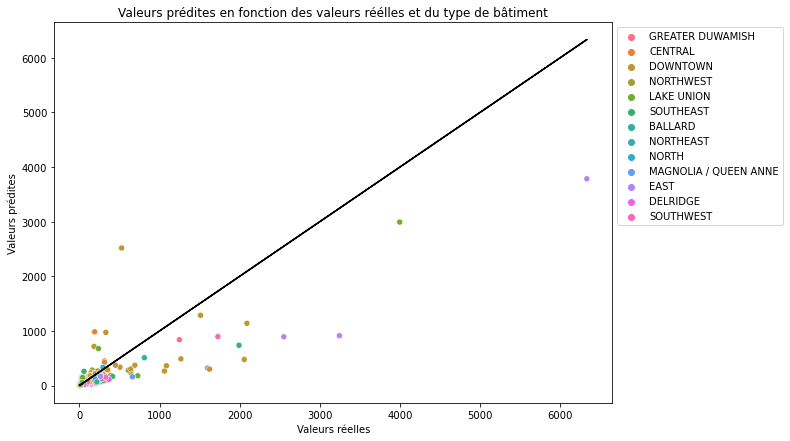

In [394]:
fc.plot_pred_class(y_test_ghg, y_pred_xgb_ghg,'Neighborhood')

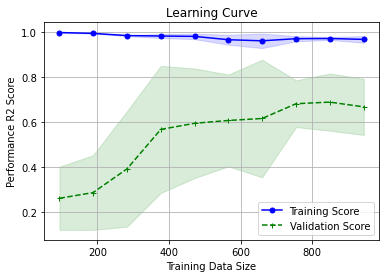

In [18]:
mod_pip_xgb = Pipeline([('preprocessor', preprocessor),
                  ('model',TransformedTargetRegressor(regressor=XGBRegressor(gamma= 0, learning_rate= 0.1, 
                                                                             max_depth= 4, n_estimators= 300), 
                                                      func=np.log, inverse_func=np.exp))])


fc.plot_learning_curve(mod_pip_xgb, X_train_ghg, y_train_ghg)

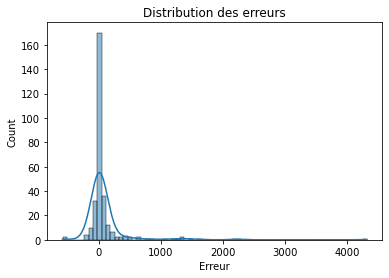

In [310]:
fc.plot_error(y_test_ghg, y_pred_xgb_ghg)

# <a id="9"></a> 7. Impact de l'Energy Star Score

Nous allons désormais tester l'impact de la variable Energy Star Score sur les performances du modèle.

In [350]:
X_ghg_ESS = data.copy().drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y_ghg_ESS = data.copy()['SiteEnergyUse(kBtu)']

In [351]:
col_quant = X_ghg_ESS.select_dtypes(['int32','float64']).columns

col_qual = X_ghg_ESS.select_dtypes(['category','object','bool']).columns

preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scale,col_quant),
    ('quali',ohe,col_qual)
])

In [352]:
X_train_ghg_ESS, X_test_ghg_ESS, y_train_ghg_ESS, y_test_ghg_ESS = train_test_split(X_ghg_ESS, y_ghg_ESS, test_size=0.2,random_state=0)

In [353]:
X_train_ghg_ESS.shape

(1180, 20)

In [354]:
X_train_ghg_ESS = X_train_ghg_ESS[X_train_ghg_ESS['ENERGYSTARScore'].isna()==False]
y_train_ghg_ESS = y_train_ghg_ESS[y_train_ghg_ESS.index.isin(list(X_train_ghg_ESS.index))]
X_test_ghg_ESS = X_test_ghg_ESS[X_test_ghg_ESS['ENERGYSTARScore'].isna()==False]
y_test_ghg_ESS = y_test_ghg_ESS[y_test_ghg_ESS.index.isin(list(X_test_ghg_ESS.index))]

In [355]:
params_xgb = {'regressor__gamma': [0,0.001,0.01,0.1,0.5,1],
              'regressor__learning_rate' : [0.01, 0.1, 0.2, 0.3, 0.5],
              'regressor__max_depth': [2,4,6,7],
              'regressor__n_estimators': [50,100, 200, 300, 400],
             }

mod_pip_ghg_ESS = grid_search_cv(XGBRegressor(),params_xgb)
mod_pip_ghg_ESS.fit(X_train_ghg_ESS,y_train_ghg_ESS)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('quanti', StandardScaler(),
                                                  Index(['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'ParkingRatioGFA'],
      dtype='object')),
                                                 ('quali',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['Neighborhood', 'LargestPropertyUseT...
                              param_grid={'regressor__gamma': [0, 0.001, 0.01,
                                                               0.1, 0.5, 1],
                                          'regressor__learning_rate': [0.01,
                                                                       0.1, 0.2,
                                                                       0.3,
                                                                       0.5],
                                          'regressor__max_depth': [2, 4, 6, 7],
                                          'regressor__n_estimators': [50, 100,
                                                                      200, 300,
                                                                      400]},
                              refit='r2', return_train_score=True,
                              scoring=('neg_root_mean_squared_error', 'r2',
                                       'neg_mean_absolute_error',
                                       'neg_median_absolute_error',
                                       'neg_mean_squared_log_error')))])

In [356]:
model_ghg_ess_resultats = fc.metrics(mod_pip_ghg_ESS)

Meilleurs paramètres {'regressor__gamma': 0, 'regressor__learning_rate': 0.5, 'regressor__max_depth': 6, 'regressor__n_estimators': 50}
Meilleur score RMSLE : -0.1349030842733912
Meilleur score RMSE : -11202264.012564793
Meilleur score R2 : 0.7586441430350537
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
90,0.585671,0.115958,0.016477,0.021824,0,0.5,6,50,"{'regressor__gamma': 0, 'regressor__learning_r...",-5.772011e+06,-3.092749e+07,-1.308436e+07,-5.395396e+06,-4.244925e+06,-1.188484e+07,1.001907e+07,24,-465788.727633,-501589.065537,-500020.94019,-422327.065515,-644210.695294,-506787.298834,74528.395912,0.77082,0.60471,0.739775,0.956527,0.721389,0.758644,0.113794,1,0.999775,0.999351,0.999701,0.999786,0.999577,0.999638,0.000162,-2.011617e+06,-5.610668e+06,-3.714051e+06,-2.163213e+06,-1.563068e+06,-3.012523e+06,1.487720e+06,80,-226981.699291,-152844.672441,-222995.992095,-184447.820016,-241223.731474,-205698.783064,32432.509502,-560131.25,-575096.875,-775057.125,-548076.125,-503681.75,-592408.625,94382.020619,379,-86605.375,-49552.875,-80795.0,-70568.1875,-76511.78125,-72806.64375,12756.922129,-0.160694,-0.240271,-0.184988,-0.146809,-0.152231,-0.176999,0.034228,258,-0.003687,-0.001842,-0.003788,-0.0029,-0.003474,-0.003138,0.000717


In [357]:
mod_pip_ghg_ESS.score(X_train_ghg_ESS,y_train_ghg_ESS)

0.9994158097353272

In [358]:
start_time = time.time()
y_pred_ghg_test_ESS = mod_pip_ghg_ESS.predict(X_test_ghg_ESS)
print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.019 s.


In [359]:
res_test_ghg_ESS = fc.metrics_pred(y_test_ghg_ESS, y_pred_ghg_test_ESS)
res_test_ghg_ESS

,RMSLE,R2
0,0.176498,0.652233


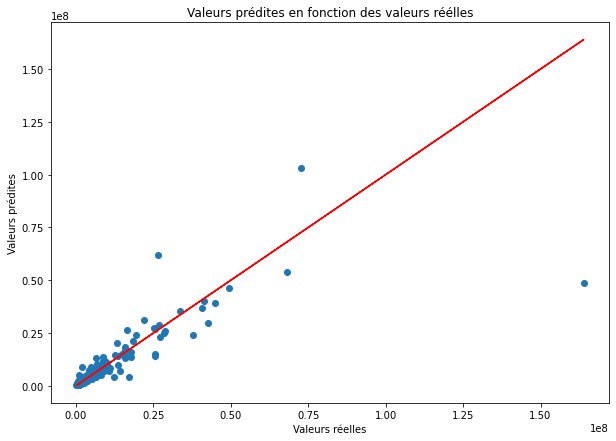

In [360]:
fc.plot_predict(y_test_ghg_ESS, y_pred_ghg_test_ESS)

Nous allons désormais tester la variable ENERGYSTARScore en la complétant à l'aide d'un knn.

In [361]:
col_quanti = X_ghg_ESS.select_dtypes(['int32','float64']).columns

In [362]:
X_ghg_ESS[col_quanti] = fc.knn_imputer(X_ghg_ESS[col_quanti])

In [363]:
X_train_ghg_ESS_k, X_test_ghg_ESS_k, y_train_ghg_ESS_k, y_test_ghg_ESS_k = train_test_split(X_ghg_ESS, y_ghg_ESS, test_size=0.2,random_state=0)

In [364]:
params_xgb = {'regressor__gamma': [0,0.001,0.01,0.1,0.5,1],
              'regressor__learning_rate' : [0.01, 0.1, 0.2, 0.3, 0.5],
              'regressor__max_depth': [2,4,6,7],
              'regressor__n_estimators': [50,100, 200, 300, 400],
             }

mod_pip_ghg_ESSk = grid_search_cv(XGBRegressor(),params_xgb)
mod_pip_ghg_ESSk.fit(X_train_ghg_ESS_k,y_train_ghg_ESS_k)
model_ghg_essk_resultats = fc.metrics(mod_pip_ghg_ESSk)

Meilleurs paramètres {'regressor__gamma': 0.01, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 2, 'regressor__n_estimators': 200}
Meilleur score RMSLE : -0.3150033808001004
Meilleur score RMSE : -9670934.048223007
Meilleur score R2 : 0.733583824838188
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
242,1.435095,0.034197,0.006835,0.000183,0.01,0.2,2,200,"{'regressor__gamma': 0.01, 'regressor__learnin...",-8.605446e+06,-2.449019e+07,-9.034029e+06,-5.059106e+06,-3.698341e+06,-1.017742e+07,7.440555e+06,10,-7.035314e+06,-5.017239e+06,-5.944296e+06,-7.108855e+06,-6.048332e+06,-6.230807e+06,775413.865898,0.5051,0.629906,0.825595,0.944511,0.762807,0.733584,0.152816,1,0.924678,0.912104,0.938824,0.912825,0.946045,0.926895,0.013643,-2.676557e+06,-4.857656e+06,-3.629905e+06,-2.196793e+06,-1.846021e+06,-3.041386e+06,1.088166e+06,48,-2.002755e+06,-1.810024e+06,-1.835700e+06,-2.066567e+06,-2.019100e+06,-1.946829e+06,103685.298598,-610879.1875,-900038.875,-807272.0,-817101.78125,-801693.125,-787396.99375,95213.968489,341,-628091.03125,-572830.6875,-558154.75,-568265.9375,-556782.25,-576824.93125,26335.178397,-0.238111,-0.396422,-0.326834,-0.318316,-0.347887,-0.325514,0.051422,65,-0.189496,-0.167732,-0.173217,-0.176549,-0.173655,-0.17613,0.007266


In [365]:
mod_pip_ghg_ESSk.score(X_train_ghg_ESS_k,y_train_ghg_ESS_k)

0.9199039629412308

In [366]:
start_time = time.time()
y_pred_ghg_test_ESS_k = mod_pip_ghg_ESSk.predict(X_test_ghg_ESS_k)
print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.04 s.


In [367]:
res_test_ghg_ESS_k = fc.metrics_pred(y_test_ghg_ESS_k, y_pred_ghg_test_ESS_k)
res_test_ghg_ESS_k

,RMSLE,R2
0,0.280578,0.698308


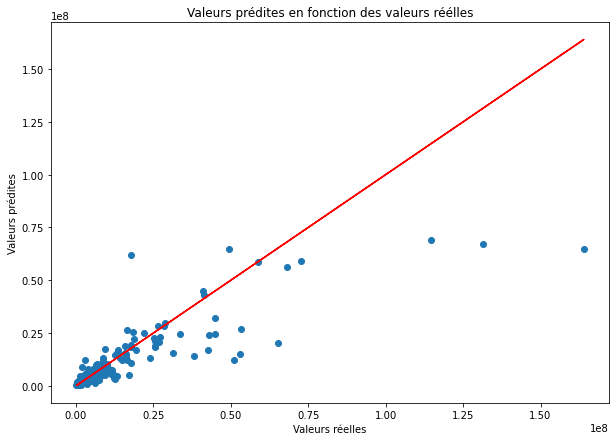

In [368]:
fc.plot_predict(y_test_ghg_ESS_k, y_pred_ghg_test_ESS_k)

In [369]:
df_comparaison = pd.concat([res_test_xgb_ghg, res_test_ghg_ESS,res_test_ghg_ESS_k], axis = 0, 
                           keys=['Sans ESS', 'Avec ESS','Avec ESS imputée'])

df_comparaison

,,RMSLE,R2
Sans ESS,0,0.457038,0.644576
Avec ESS,0,0.176498,0.652233
Avec ESS imputée,0,0.280578,0.698308


L'EnergyStarScore qu'elle soit imputée ou non, offre de meilleures performances que le modèle de base. La variable imputée à l'aide d'un knn imputer offre des performances légèrement supérieures.

En sachant que la variable est fastidieuse à calculer, il nous faudrait un avis métier pour savoir si le gain de performances obtenu est suffisamment conséquent pour l'intégrer au modèle ou si il n'est pas suffisant.

Ici, nous continuerons l'étude avec le modèle intégrant l'EnergyStarScore imputée.

# <a id="10"></a> 8. Feature importance 

In [373]:
mod_xgb_ghg = Pipeline([('preprocessor', preprocessor),
                  ('model',TransformedTargetRegressor(regressor=XGBRegressor(gamma= 0.01, learning_rate= 0.2, 
                                                                             max_depth= 2, 
                                                                             n_estimators= 200), 
                                                      func=np.log, inverse_func=np.exp))])


mod_xgb_ghg.fit(X_train_ghg_ESS_k, y_train_ghg_ESS_k)
print(mod_xgb_ghg.score(X_train_ghg_ESS_k, y_train_ghg_ESS_k))
print(mod_xgb_ghg.score(X_test_ghg_ESS_k,y_test_ghg_ESS_k))

0.9199039629412308
0.6983083053851763


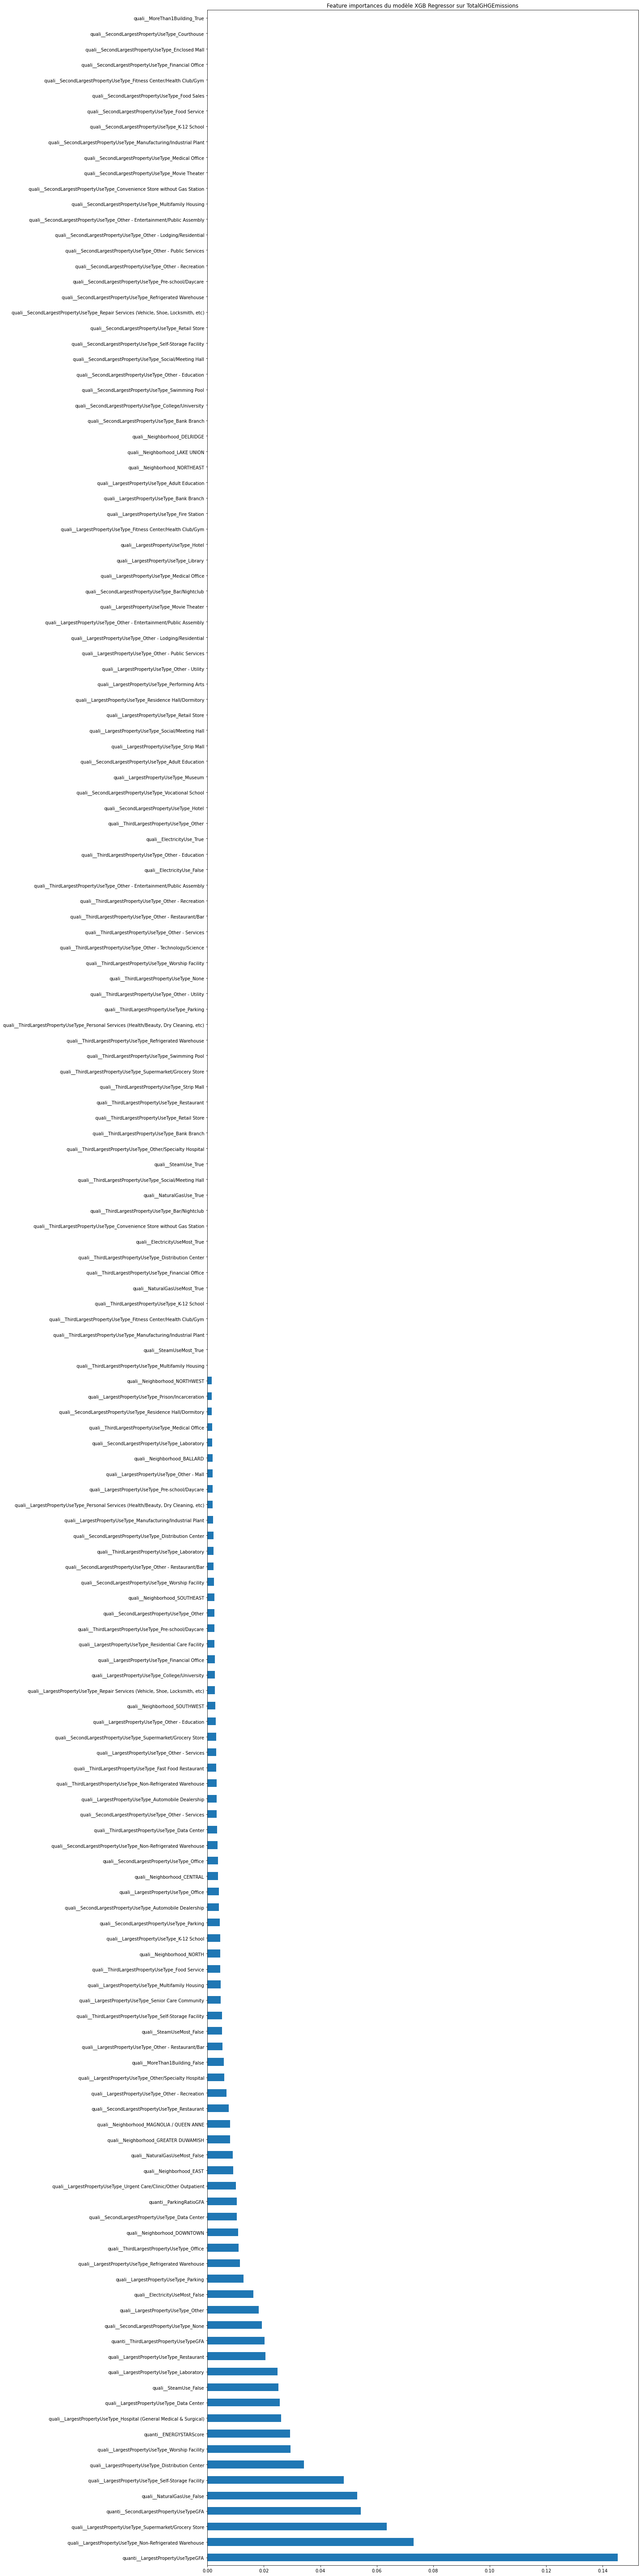

In [374]:
features_importance = mod_xgb_ghg['model'].regressor_.feature_importances_
name_features = mod_xgb_ghg['preprocessor'].get_feature_names_out()
df_features_importance = pd.Series(features_importance, index=name_features).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(20,80))
df_features_importance.plot.barh(ax=ax)
ax.set_title("Feature importances du modèle XGB Regressor sur TotalGHGEmissions")
fig.tight_layout()
plt.savefig('All Feature importance GHG')

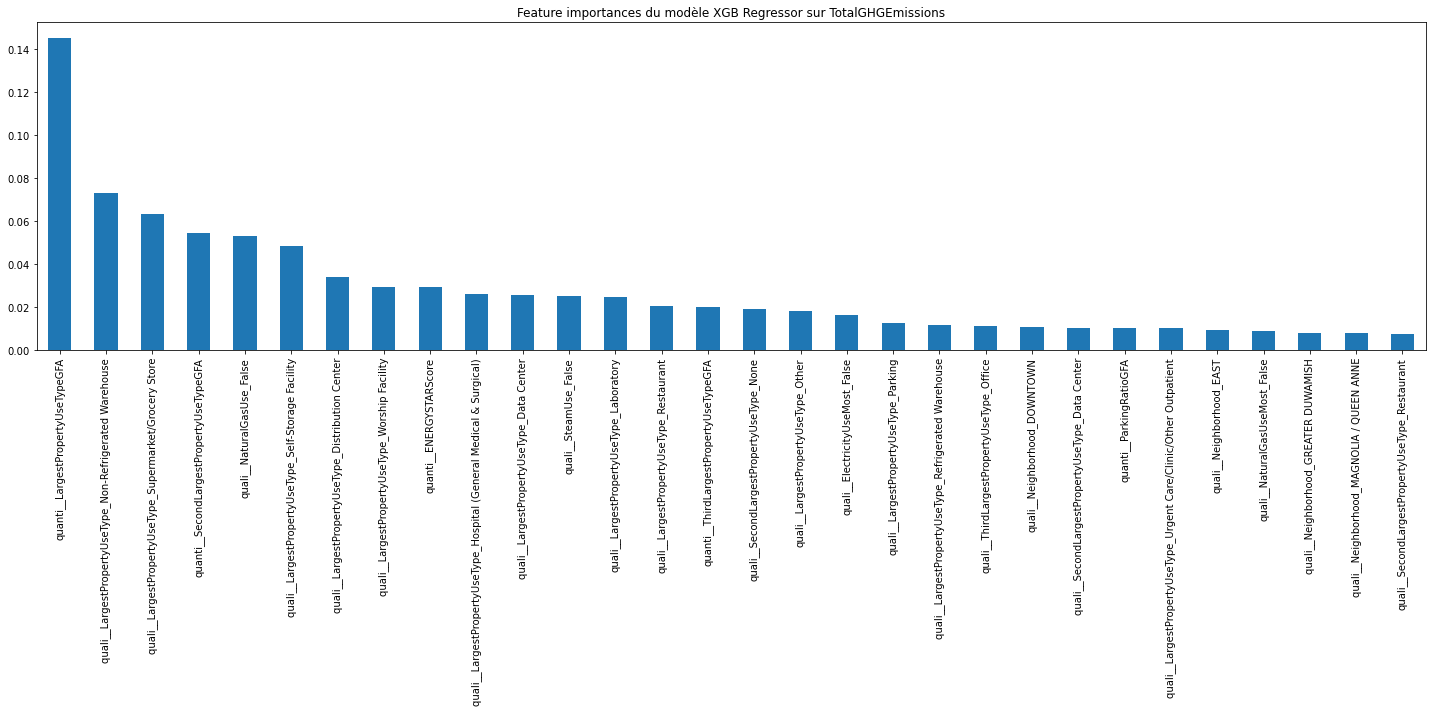

In [375]:
fig, ax = plt.subplots(figsize=(20,10))
df_features_importance.head(30).plot.bar(ax=ax)
ax.set_title("Feature importances du modèle XGB Regressor sur TotalGHGEmissions")
fig.tight_layout()
plt.savefig('Feature importance GHG')

On constate certaines features ont plus d'importance dans la modélisation de *TotalGHGEmissions*. En effet, nous avons notamment les variables:

- LargestPropertyUseTypeGFA,
- LargestPropertyUseType,
- SecondLargestPropertyUseTypeGFA,
- NaturalGasUse,
- ENERGYSTARScore,
- SteamUse,
- ThirdLargestPropertyUseTypeGFA,
- SecondLargestPropertyUseType,
- ElectricityUseMost,
- Neighborhood,
- ParkingRatioGFA, 
- NaturalGasUseMost.

qui ont un fort impact dans la modélisation.

Nous allons donc tenter de réentrainer un nouveau modèle de XGB Regressor avec seulement les variables jugées les plus importantes afin de voir si elles suffisent à obtenir des performances équivalentes ou meilleures.

In [377]:
var_select = ['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','LargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
             'Neighborhood','ParkingRatioGFA','NaturalGasUse','SecondLargestPropertyUseType','ElectricityUseMost',
             'NaturalGasUseMost','ENERGYSTARScore','SteamUse']
X_final = data.copy()[var_select]
y_final = data.copy()['TotalGHGEmissions']

In [378]:
col_quant = X_final.select_dtypes(['int32','float64']).columns
col_qual = X_final.select_dtypes(['category','object','bool']).columns

preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scale,col_quant),
    ('quali',ohe,col_qual)
])

In [379]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, test_size=0.2, random_state = 0)

In [380]:
mod_xgb_f = Pipeline([('preprocessor', preprocessor),
                  ('model',TransformedTargetRegressor(regressor=XGBRegressor(gamma= 0.01, learning_rate= 0.2, 
                                                                             max_depth= 2, 
                                                                             n_estimators= 200), 
                                                      func=np.log, inverse_func=np.exp))])

In [386]:
mod_xgb_f.fit(X_train_f,y_train_f)
print(mod_xgb_f.score(X_train_f,y_train_f))
print(mod_xgb_f.score(X_test_f,y_test_f))

0.9434184434420267
0.5973176285129954


In [385]:
df_comparaison_f = pd.DataFrame(data={'train_score':[mod_pip_ghg_ESSk.score(X_train_ghg_ESS_k,y_train_ghg_ESS_k),mod_xgb_f.score(X_train_f,y_train_f)],
                                      'test_score': [mod_pip_ghg_ESSk.score(X_test_ghg_ESS_k,y_test_ghg_ESS_k),mod_xgb_f.score(X_test_f,y_test_f)]},
                               index = ['Modèle initial', 'Modèle feature select'])

df_comparaison_f

,train_score,test_score
Modèle initial,0.919904,0.698308
Modèle feature select,0.943418,0.597318


Le modèle entraîné avec les 30 features les plus importantes retourne des performances inférieures au modèle choisi. Il n'est donc pas judicieux de ne garder que ces features pour la modélisation.